In [1]:
import torch
import torch.functional as func
import torch.nn as nn

import numpy as np
import random
import tqdm
import argparse
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from models.Network import Face_Detection_Model, rgbdp_v1_twostep_model, rgbdp_v2_twostep_model, rgbdp_v3_twostep_model

import os
import os.path as osp
from re import S

import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T 
import matplotlib.pyplot as plt
# from dataloader.dataloader import load_dataset, load_test_dataset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# rgb_model = Face_Detection_Model(3).to(device)
# basic_model = rgbdp_v3_twostep_model(device=device)
cloudnet = rgbdp_v3_twostep_model(device=device)
# cloudnet = rgbdp_v1_twostep_model(device=device)
cloudnet_v2 = rgbdp_v2_twostep_model(device=device)

# rgb = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0825_total_rgb/epoch_311_model.pth")
# basic = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v3/epoch_213_model.pth")
cloud = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v3/epoch_213_model.pth")
# cloud = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v1/epoch_165_model.pth")
cloud_v2 = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v2/epoch_999_model.pth")

# rgb_model.load_state_dict(rgb['model_state_dict'])
# basic_model.load_state_dict(basic['model_state_dict'])
cloudnet.load_state_dict(cloud['model_state_dict'])
cloudnet_v2.load_state_dict(cloud_v2['model_state_dict'])

sigmoid = nn.Sigmoid()
loss_fn = nn.BCEWithLogitsLoss()

g = torch.Generator()
g.manual_seed(1)

def seed_worker(worker_id):
    np.random.seed(1)
    random.seed(1)        

In [3]:
class Face_Data(Dataset):

    def __init__(self, data_paths, crop=False):
        self.data_paths = data_paths
        self.crop = crop
        
        normalize = T.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        self.transforms = T.Compose([
            T.ToTensor(),
            normalize
        ])   
        self.transforms2 = T.Compose([
            T.ToTensor()
        ])               
    
    def __getitem__(self, index):
        rgb_path = self.data_paths[index][0]
        cloud_path = self.data_paths[index][1]
        depth_path = self.data_paths[index][2]   
             
        # crop setting
        crop_width = 90
        crop_height = 150
        mid_x, mid_y = 90, 90
        offset_x, offset_y = crop_width//2, crop_height//2
        
        # RGB open and crop 
        rgb_data = cv2.imread(rgb_path)
        rgb_data = cv2.cvtColor(rgb_data, cv2.COLOR_BGR2RGB)
        rgb_data = cv2.resize(rgb_data, (180,180), interpolation=cv2.INTER_CUBIC)
        if self.crop == True:
            rgb_data = rgb_data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]     
        if self.transforms is not None :
            rgb_data = self.transforms(rgb_data)
            
        # Depth open 
        depth_data = cv2.imread(depth_path)
        depth_data = cv2.cvtColor(depth_data, cv2.COLOR_BGR2GRAY)
        depth_data = cv2.resize(depth_data, (180,180), interpolation=cv2.INTER_CUBIC)        
        if self.transforms2 is not None :
            depth_data = self.transforms2(depth_data)            
            
        # Point Cloud(192, 256, 3) open and crop 
        cloud_data = np.load(cloud_path)
        cloud_data = cv2.resize(cloud_data, (180,180), interpolation=cv2.INTER_CUBIC)
        cloud_data += 5
        if self.crop == True:
            cloud_data = cloud_data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]
        
        # Point Cloud and Depth Scaling
        shift_value = 0
        xcoor = np.array(cloud_data[:, :, 0] + shift_value)
        ycoor = np.array(cloud_data[:, :, 1] + shift_value)
        zcoor = np.array(cloud_data[:, :, 2] + shift_value)
        # depth = np.array(cloud_data[:, :, 3] + shift_value)

        # Stadardivation
        # xcoor = (xcoor-xcoor.mean())/xcoor.std()
        # ycoor = (ycoor-ycoor.mean())/ycoor.std()
        # zcoor = (zcoor-zcoor.mean())/zcoor.std()
        # depth = (depth-depth.mean())/depth.std()    
        
        # Min Max         
        xcoor = (xcoor-xcoor.min())/(xcoor.max()-xcoor.min())
        ycoor = (ycoor-ycoor.min())/(ycoor.max()-ycoor.min())
        zcoor = (zcoor-zcoor.min())/(zcoor.max()-zcoor.min())
        # depth = (depth-depth.min())/(depth.max()-depth.min())  
        
        scaled_cloud_data = np.concatenate([xcoor[np.newaxis,:],ycoor[np.newaxis,:],zcoor[np.newaxis,:]]) 
        # scaled_depth_data = depth[np.newaxis,:]
        
        # label - { 0 : real , 1 : mask }
        if 'bonafide' in rgb_path :
            label = 0
        elif 'attack_mask' in rgb_path :
            label = 1
        elif 'attack_replay' in rgb_path :
            label = 1
        elif 'attack_paper' in rgb_path :
            label = 1
        # return rgb_data, scaled_cloud_data, scaled_depth_data, label
        return rgb_data, scaled_cloud_data, depth_data, label
    def __len__(self):
        return len(self.data_paths)
    
    
def load_dataset(args): 
        
    ## Input : RGB(3-channel) + Depth(1-channel) + Point_Cloud(3-channel)
    data_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/1. Indoor'
    npy_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/NPY_Files/1. Indoor'

    traindata_count = [i for i in range(1,10)] # 1~9
    testdata_count = [i for i in range(10,13)]  # 10~12    
 
    train_img_paths = []
    for i in traindata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB 
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]       
        
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        train_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            train_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            train_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            train_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
 
    test_img_paths = []
    for i in testdata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]        
        
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        test_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            test_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            test_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            test_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
        
    random.shuffle(train_img_paths)
    random.shuffle(test_img_paths)

    print(len(train_img_paths))
    print(len(test_img_paths))
    
#     train_dataset=Face_Data(train_img_paths, False)
#     test_dataset=Face_Data(test_img_paths, False) 

    return train_img_paths, test_img_paths


def load_test_dataset(args, dir_name): 
        
    ## Input : RGB(3-channel) + Depth(1-channel) + Point_Cloud(3-channel)
    LDFAS_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/'
    data_path = osp.join(LDFAS_path, dir_name)
    npy_path = osp.join(LDFAS_path, "NPY_Files", dir_name)
         
    testdata_count = [i for i in range(1,13)]  # 1~12    
#     testdata_count = [i for i in range(7,13)]  # 1~12    
    test_img_paths = []
    for i in testdata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]        
               
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        test_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            test_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            test_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            test_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
     
    random.shuffle(test_img_paths)
    print(len(test_img_paths))
    
#     test_dataset=Face_Data(test_img_paths, False) 

    return test_img_paths


In [4]:
args = "rpm"

_, indoor_test_paths = load_dataset(args)
outdoor_test_paths = load_test_dataset(args, "2. Outdoor")
darkdoor_test_pathst = load_test_dataset(args, "3. Indoor_dark")

indoor_testset=Face_Data(indoor_test_paths, False)
outdoor_testset=Face_Data(outdoor_test_paths, False)
darkdoor_testset=Face_Data(darkdoor_test_pathst, False)

indoor_dataloader= DataLoader(indoor_testset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)
outdoor_dataloader = DataLoader(outdoor_testset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)
darkdoor_dataloader = DataLoader(darkdoor_testset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)    

720
240
960
960


In [5]:
3/0

ZeroDivisionError: division by zero

In [ ]:
cloudnet.eval()
cloudnet_v2.eval()

bonafide_label = []
attacks_label = []
bonafide_features = []
attacks_features = []

v2_bonafide_features = []

for data in indoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    feature = cloudnet(rgb, depth, cloud)
    feature2 = cloudnet_v2(rgb, depth, cloud)
#     logits_cloud = cloudnet(rgb, depth, cloud)
#     logits_cloud = logits_cloud[:,0]
    
#     probs_cloud = sigmoid(logits_cloud)
    
    if label.cpu() == 0:
        bonafide_label += label.cpu().detach().tolist() 
        bonafide_features += feature.cpu().detach().tolist()
        v2_bonafide_features += feature2.cpu().detach().tolist()


In [ ]:
len(bonafide_features)

In [ ]:
len(v2_bonafide_features)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for i in range(60):
    plt.hist(bonafide_features[i])

In [ ]:
for i in range(60):
    plt.hist(v2_bonafide_features[i])

In [ ]:
for i in range(60):
    plt.hist(bonafide_features[i])
    plt.title(len(bonafide_features[i]))
#     plt.xlim((0,0.5))
    plt.show()

In [ ]:
for i in range(60):
    plt.hist(v2_bonafide_features[i])
    plt.title(len(v2_bonafide_features[i]))
    plt.show()
    

In [ ]:
len(v2_bonafide_features[i])

In [ ]:
3/0

In [6]:
bonafide_label = []
attacks_label = []
bonafide_features = []
attacks_features = []

v2_bonafide_features = []

for data in outdoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    feature = cloudnet(rgb, depth, cloud)
    feature2 = cloudnet_v2(rgb, depth, cloud)
#     logits_cloud = cloudnet(rgb, depth, cloud)
#     logits_cloud = logits_cloud[:,0]
    
#     probs_cloud = sigmoid(logits_cloud)
    
    if label.cpu() == 0:
        bonafide_label += label.cpu().detach().tolist() 
        bonafide_features += feature.cpu().detach().tolist()
        v2_bonafide_features += feature2.cpu().detach().tolist()


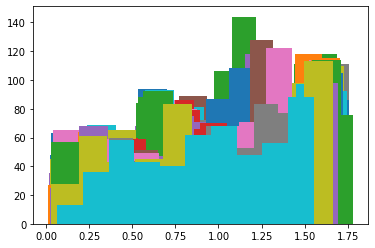

In [7]:
for i in range(60):
    plt.hist(bonafide_features[i])

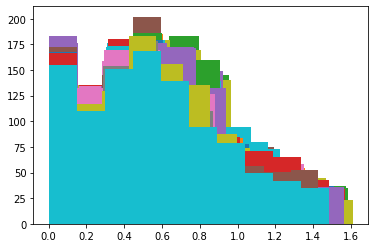

In [8]:
for i in range(60):
    plt.hist(v2_bonafide_features[i])

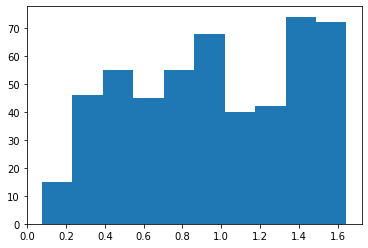

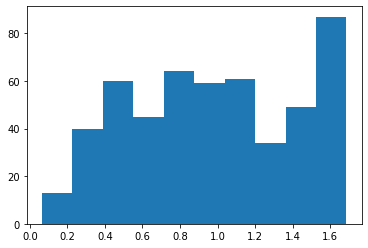

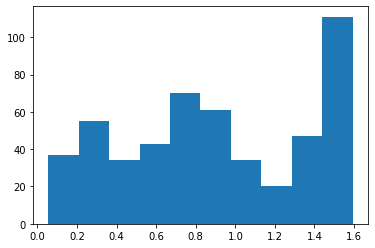

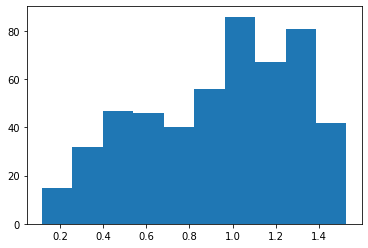

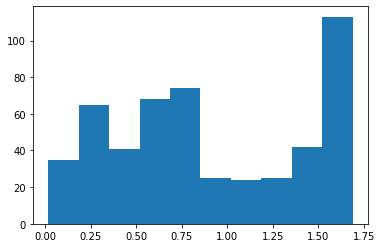

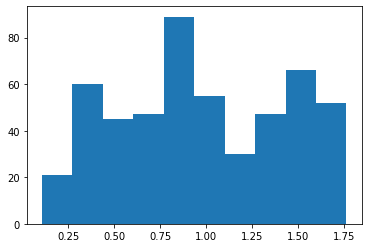

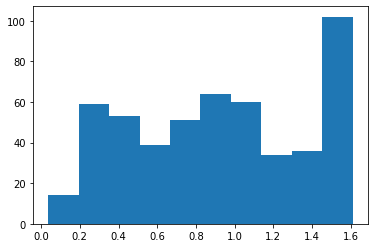

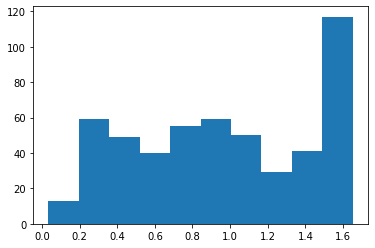

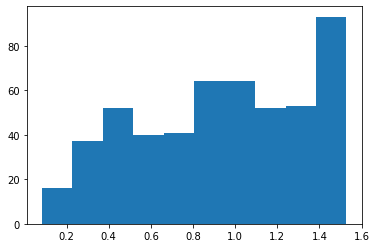

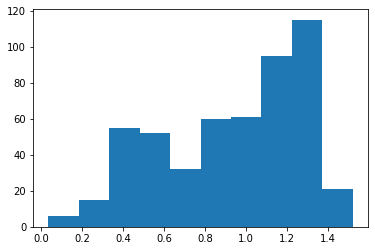

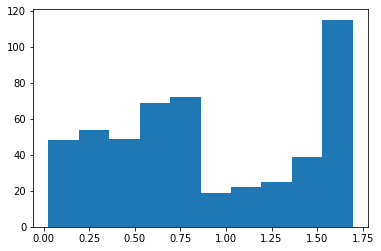

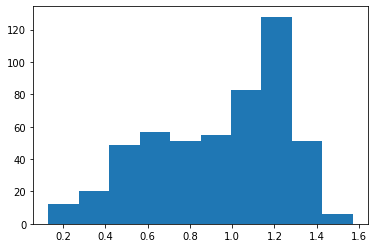

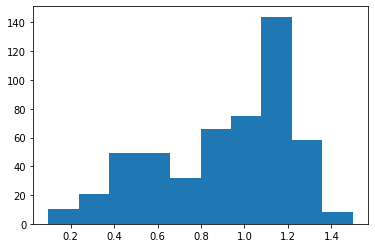

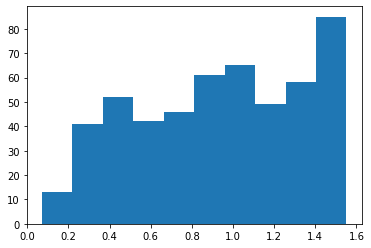

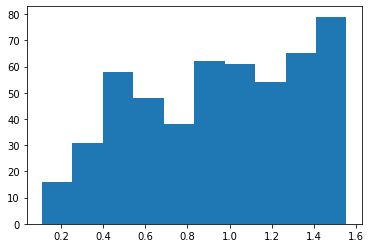

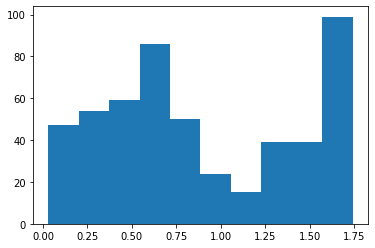

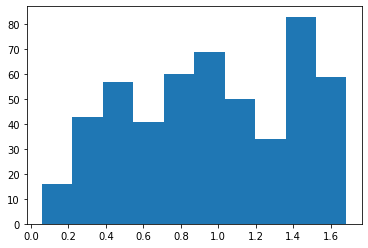

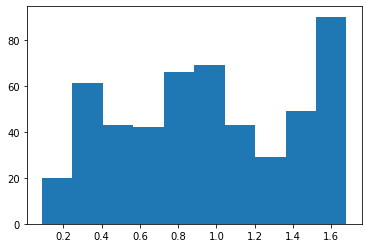

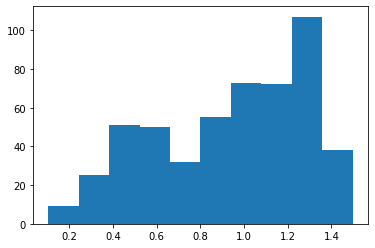

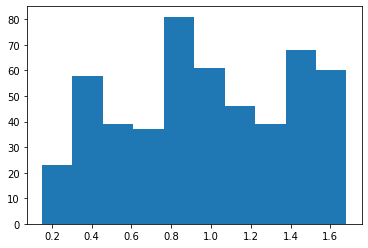

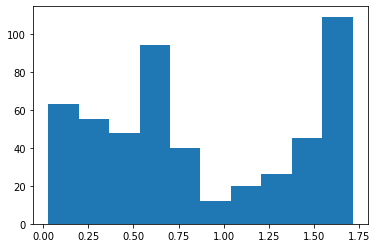

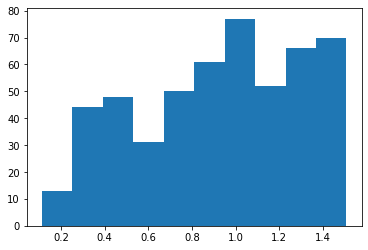

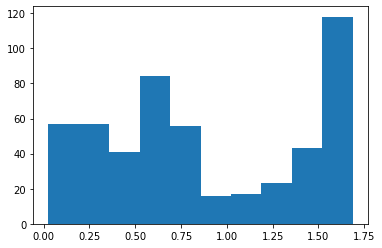

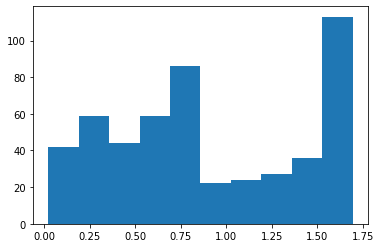

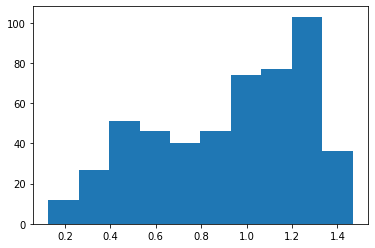

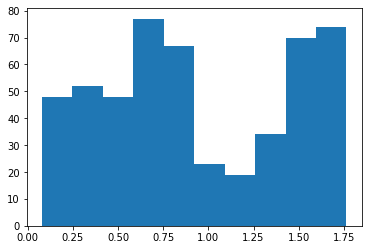

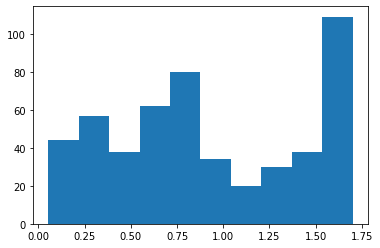

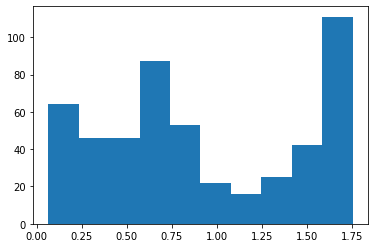

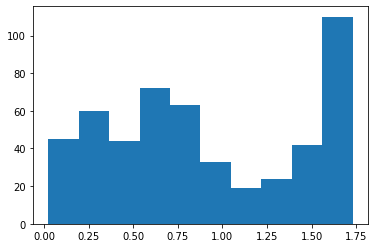

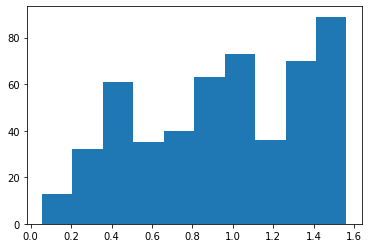

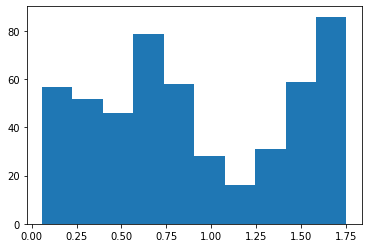

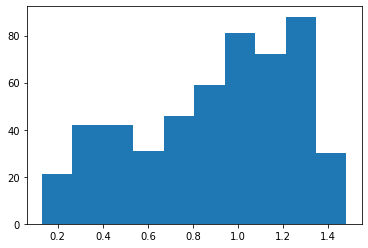

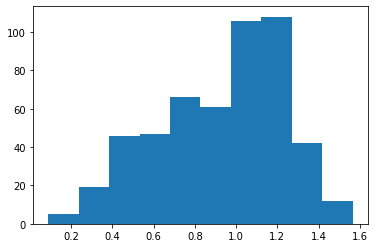

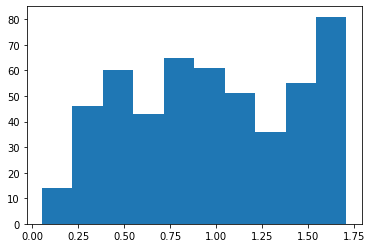

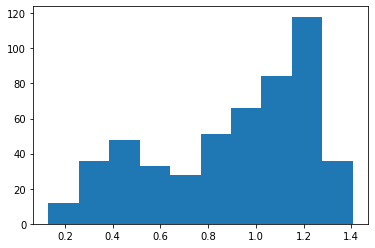

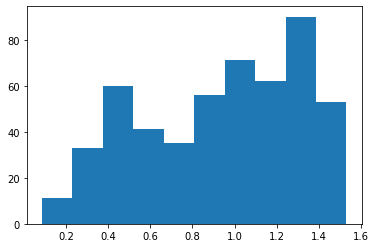

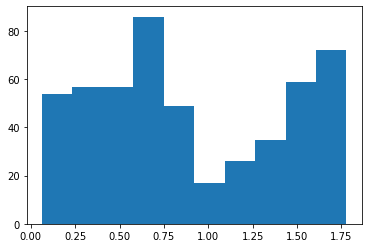

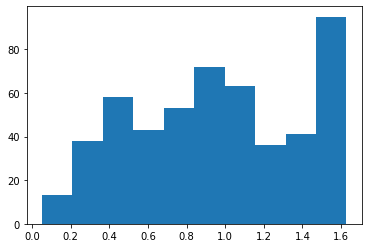

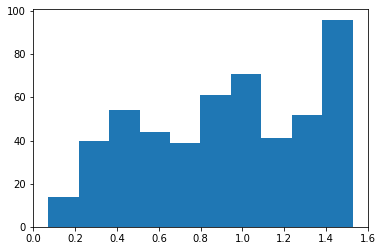

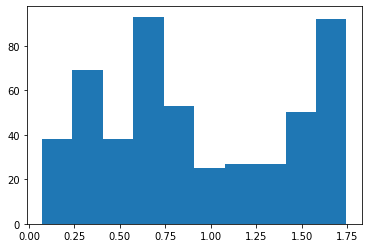

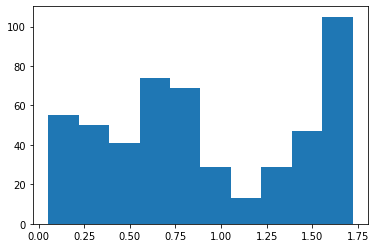

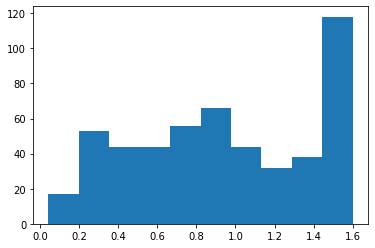

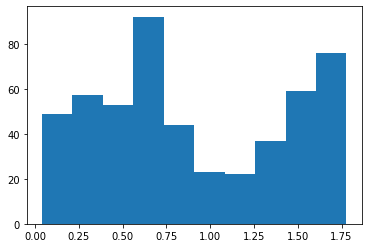

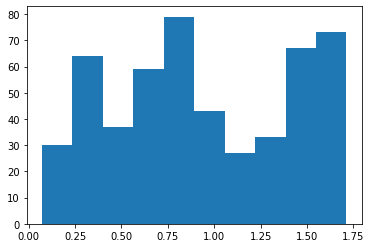

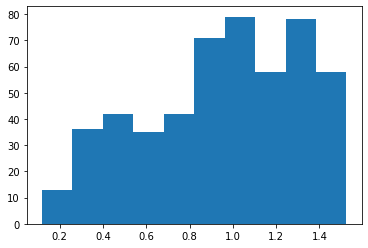

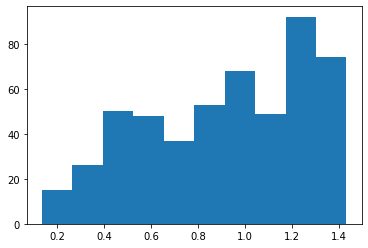

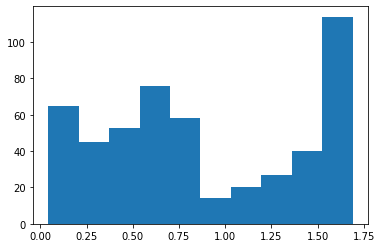

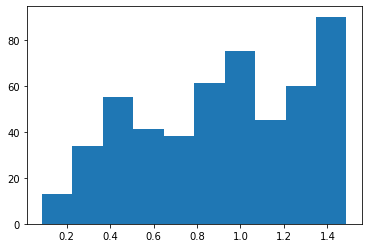

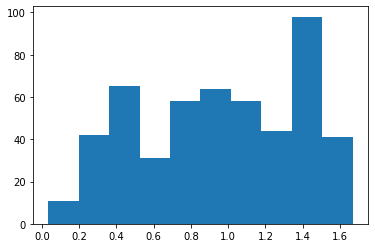

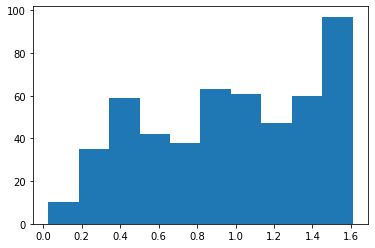

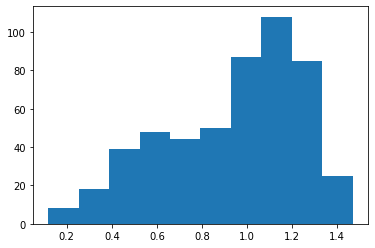

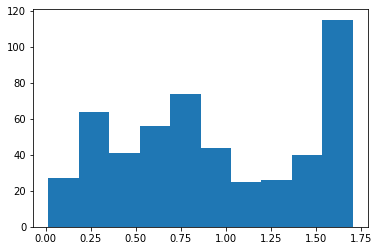

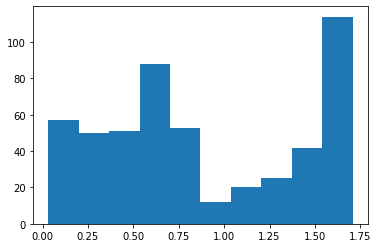

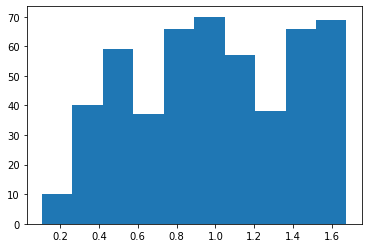

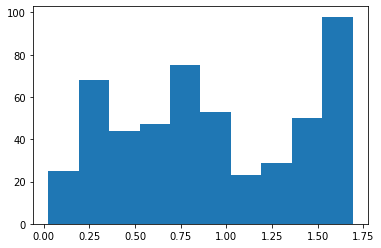

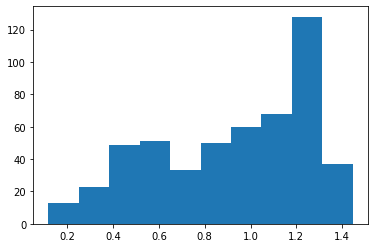

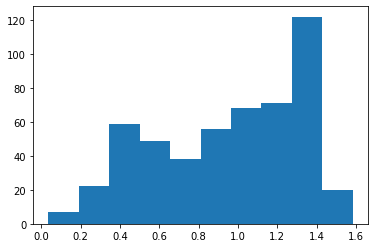

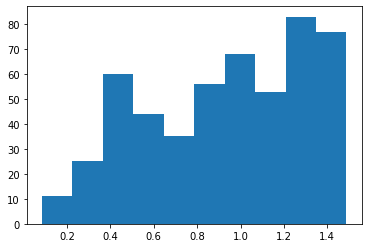

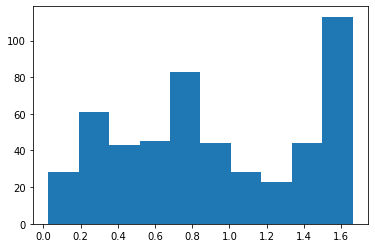

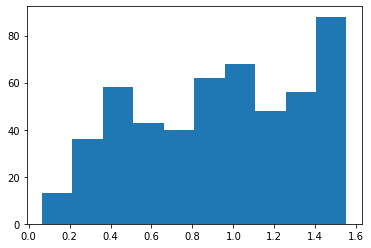

In [9]:
for i in range(60):
    plt.hist(bonafide_features[i])
    plt.show()

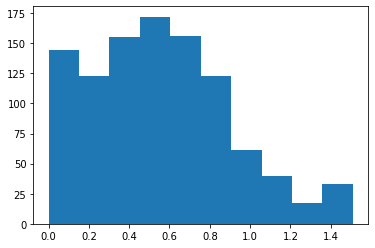

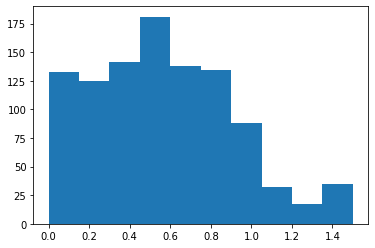

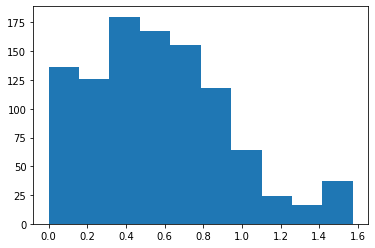

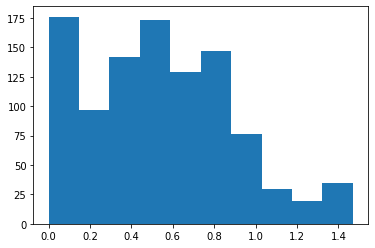

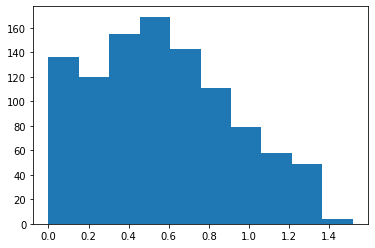

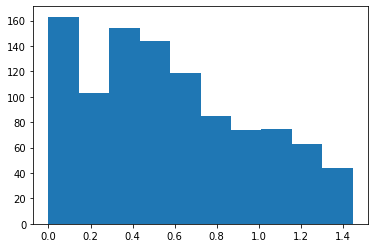

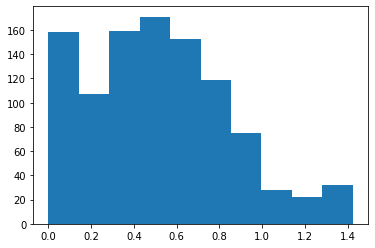

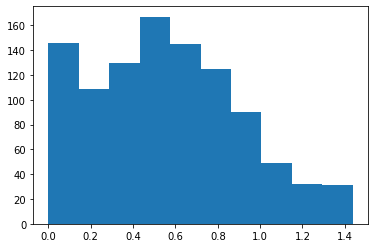

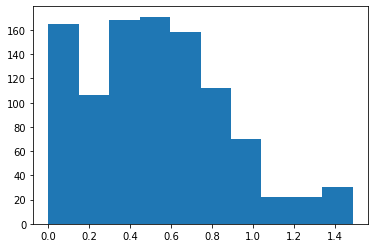

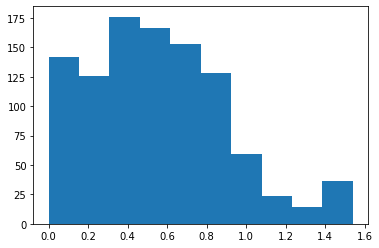

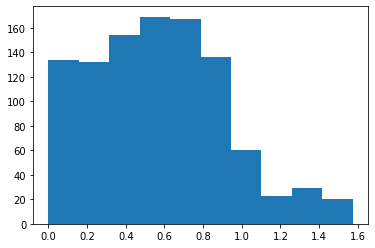

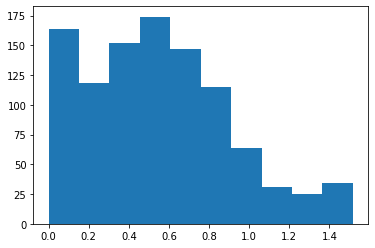

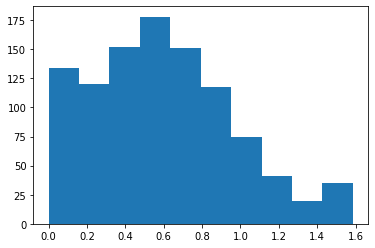

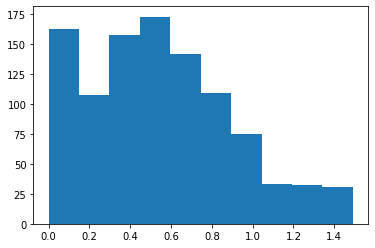

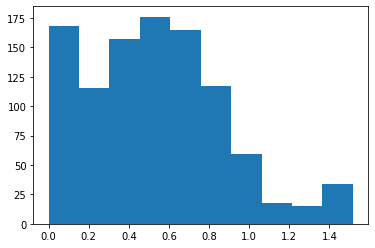

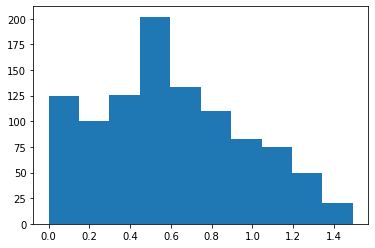

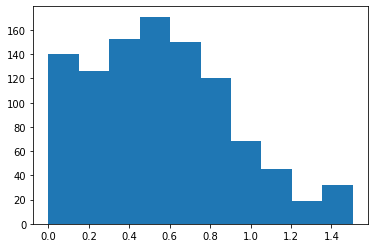

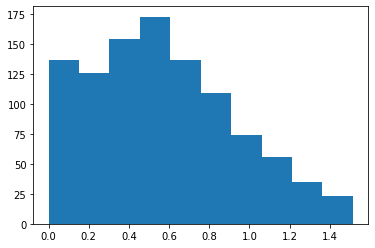

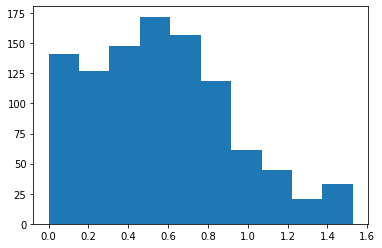

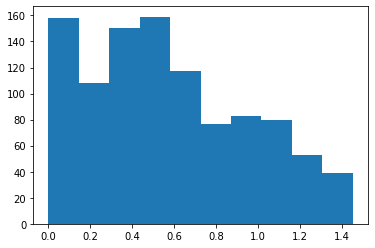

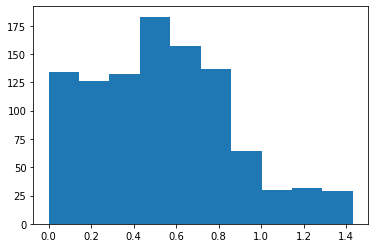

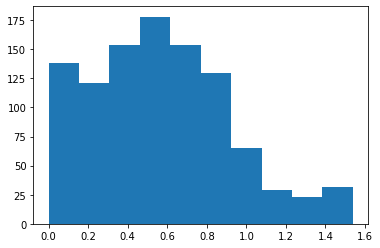

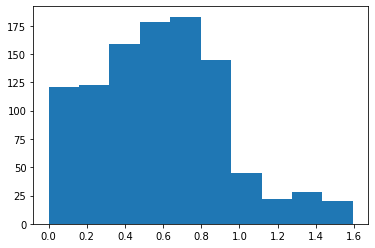

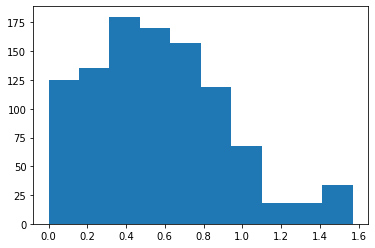

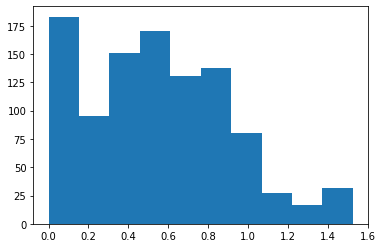

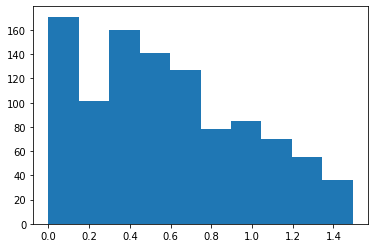

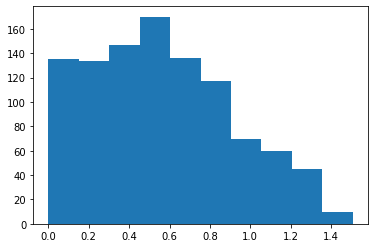

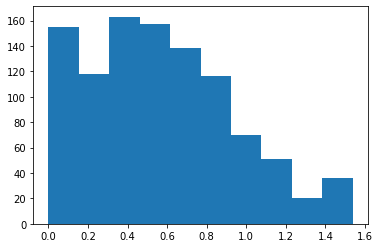

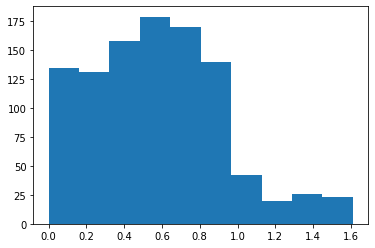

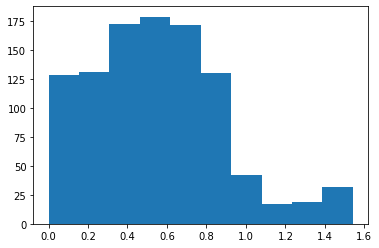

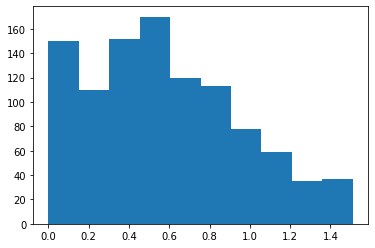

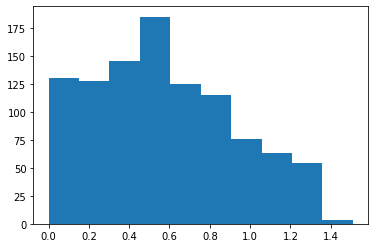

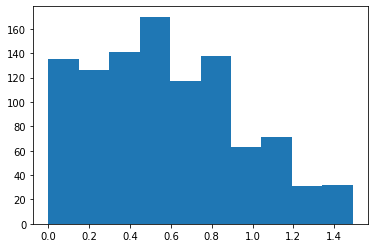

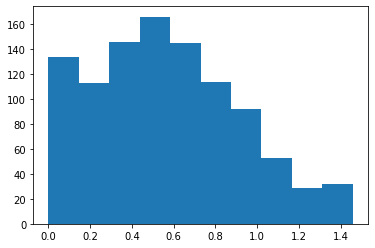

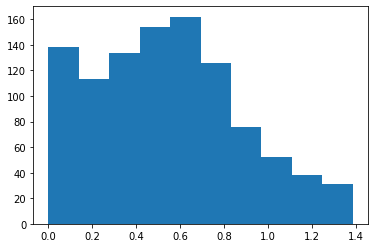

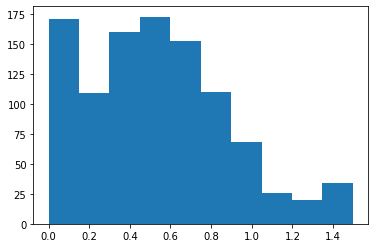

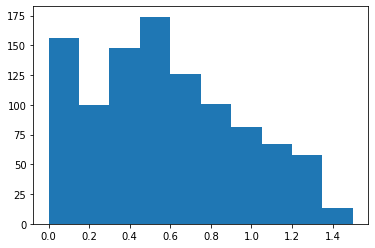

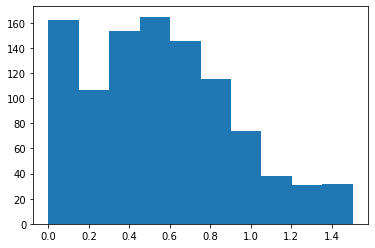

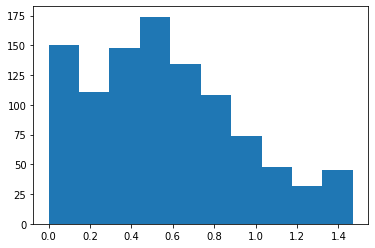

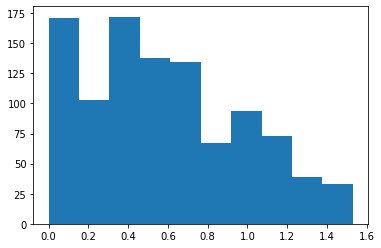

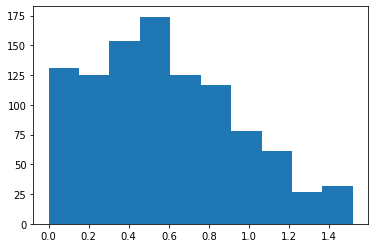

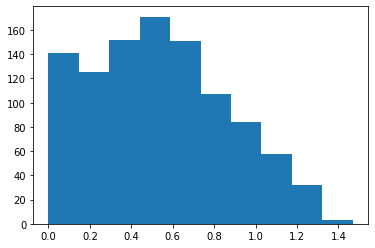

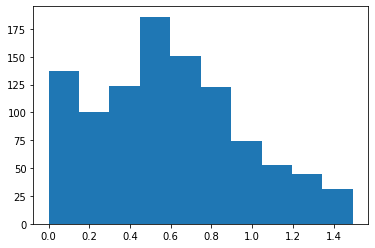

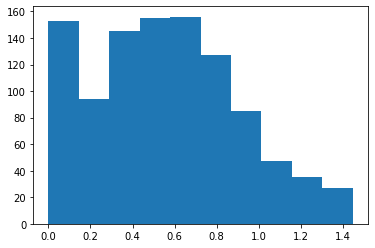

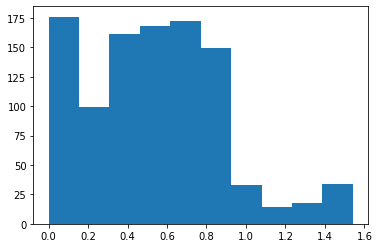

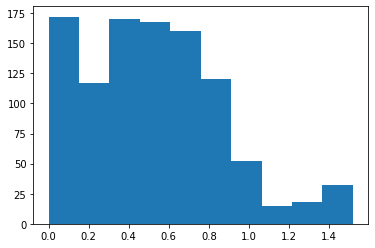

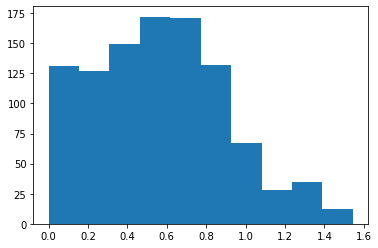

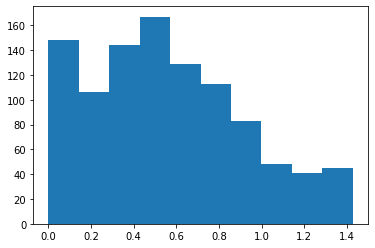

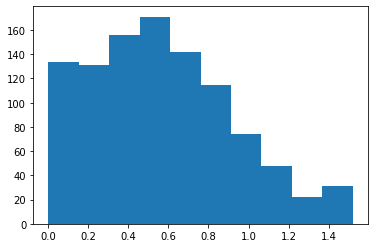

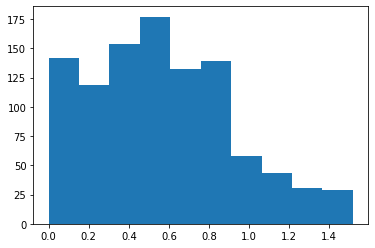

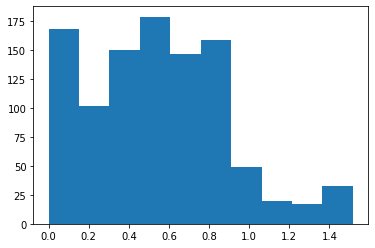

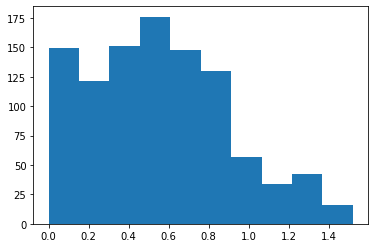

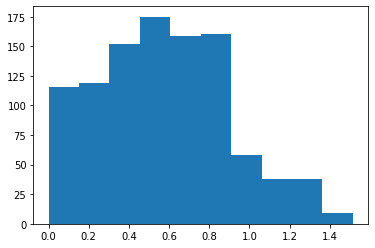

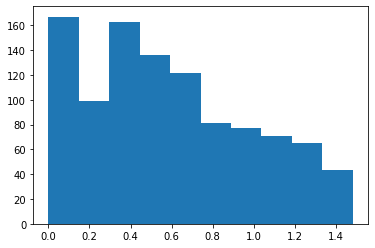

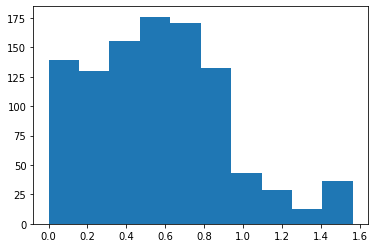

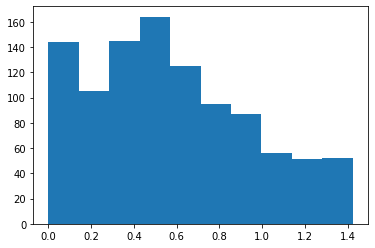

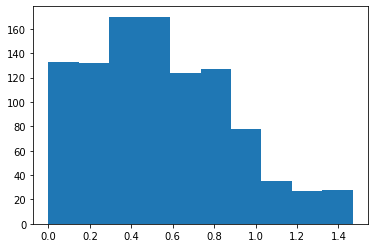

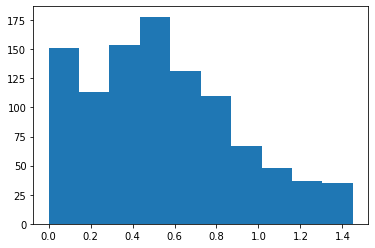

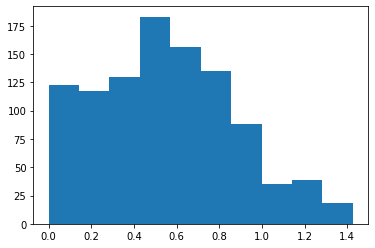

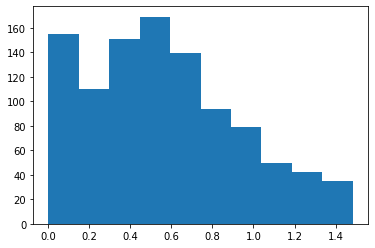

In [10]:
for i in range(60):
    plt.hist(v2_bonafide_features[i])
    plt.show()

In [11]:
bonafide_label = []
attacks_label = []
bonafide_features = []
attacks_features = []

v2_bonafide_features = []

for data in darkdoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    feature = cloudnet(rgb, depth, cloud)
    feature2 = cloudnet_v2(rgb, depth, cloud)
#     logits_cloud = cloudnet(rgb, depth, cloud)
#     logits_cloud = logits_cloud[:,0]
    
#     probs_cloud = sigmoid(logits_cloud)
    
    if label.cpu() == 0:
        bonafide_label += label.cpu().detach().tolist() 
        bonafide_features += feature.cpu().detach().tolist()
        v2_bonafide_features += feature2.cpu().detach().tolist()


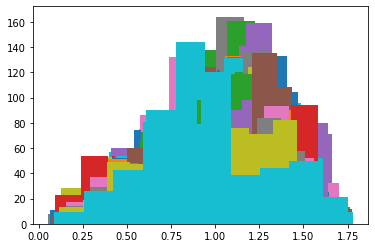

In [12]:
for i in range(60):
    plt.hist(bonafide_features[i])

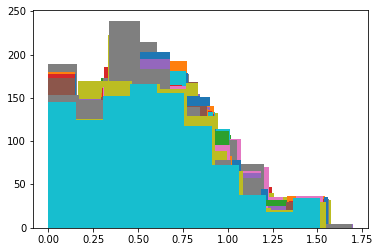

In [13]:
for i in range(60):
    plt.hist(v2_bonafide_features[i])

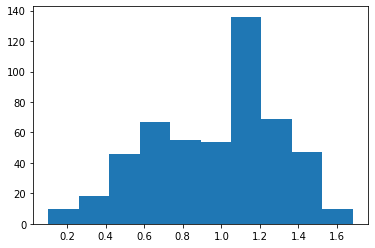

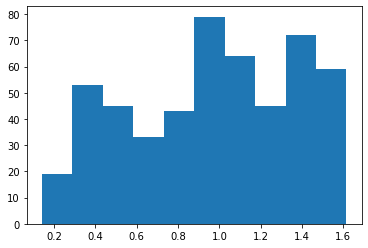

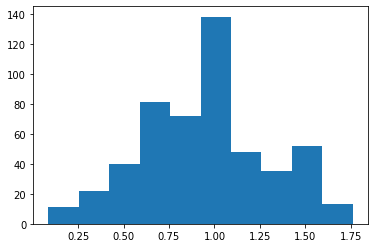

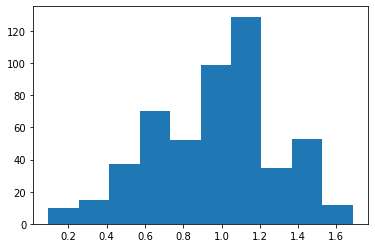

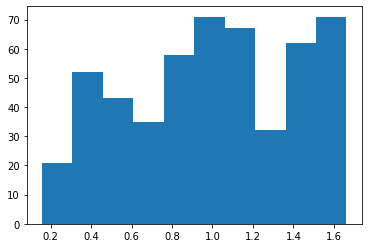

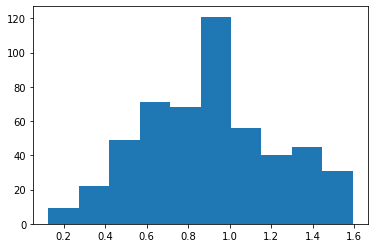

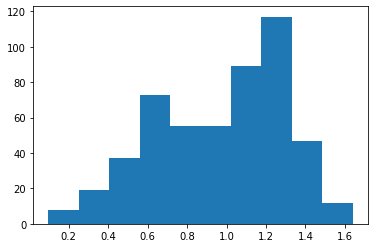

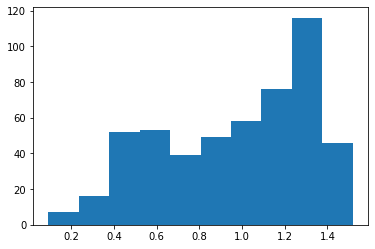

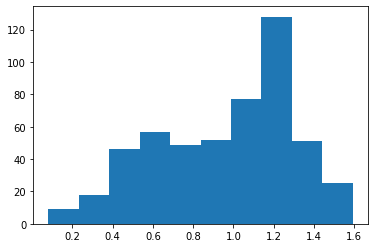

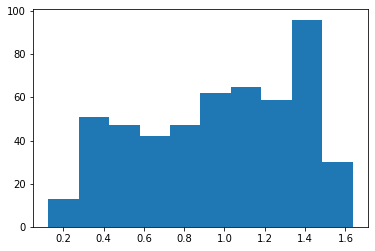

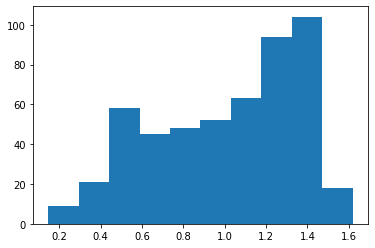

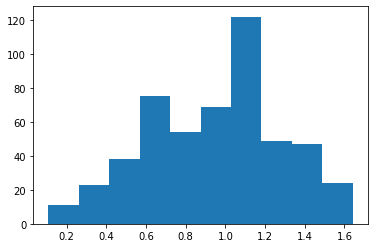

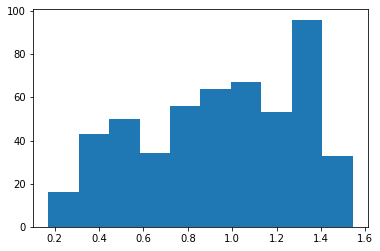

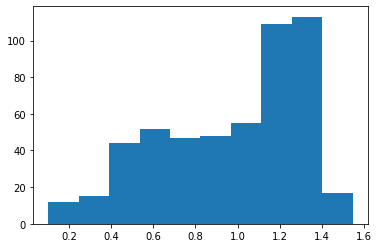

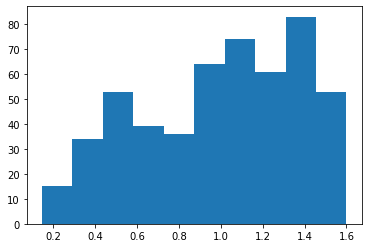

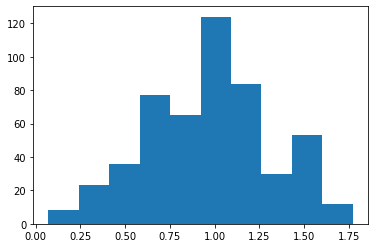

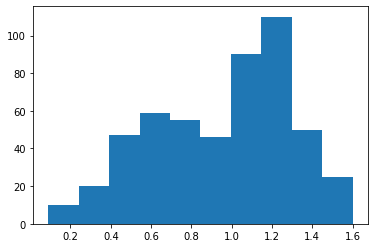

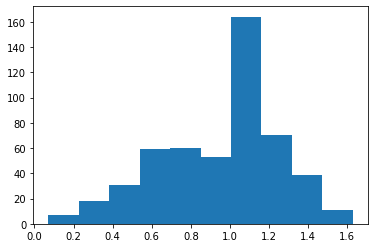

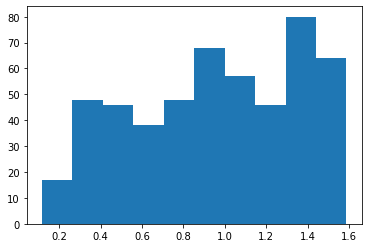

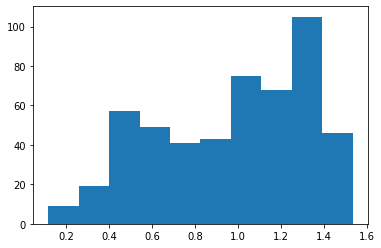

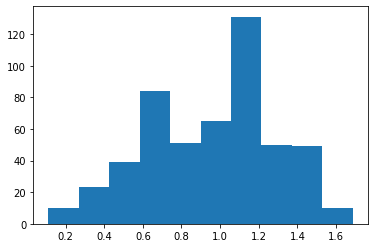

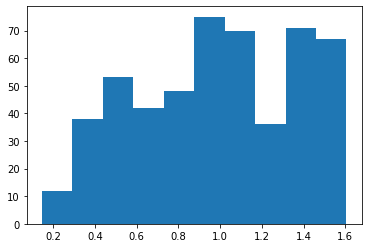

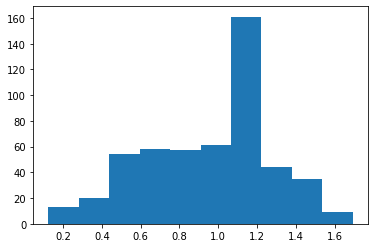

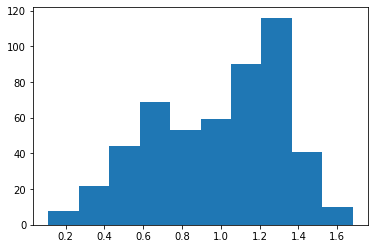

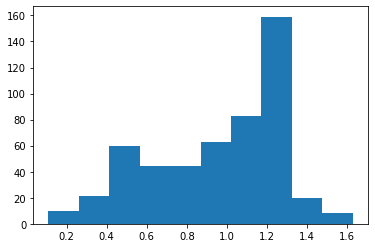

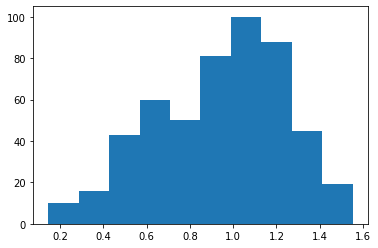

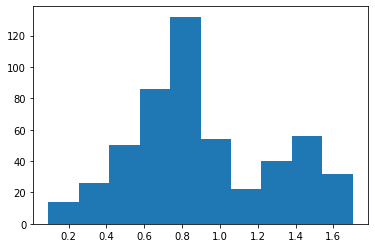

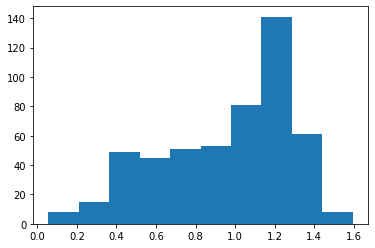

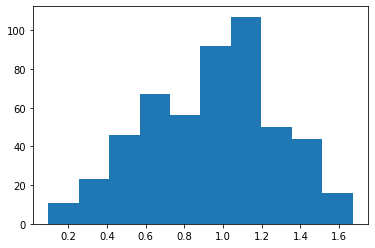

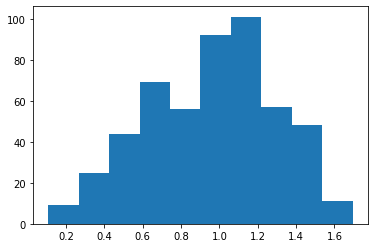

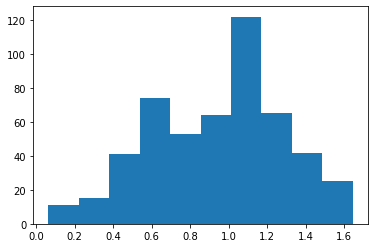

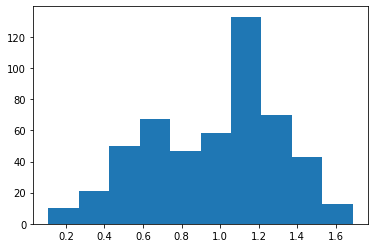

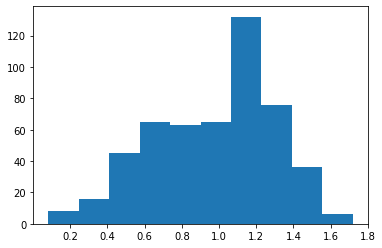

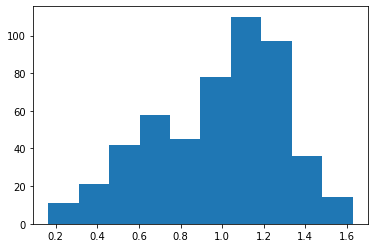

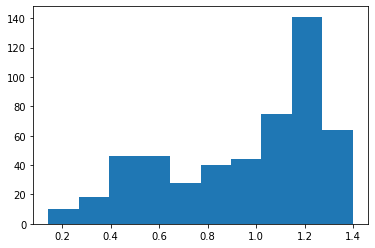

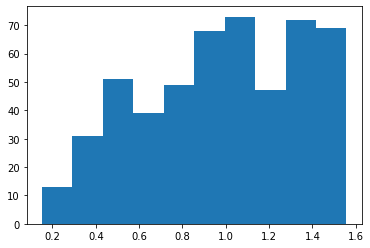

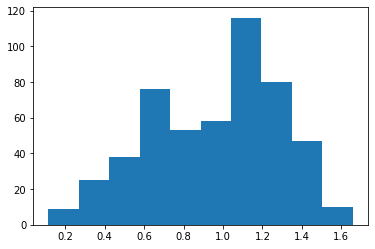

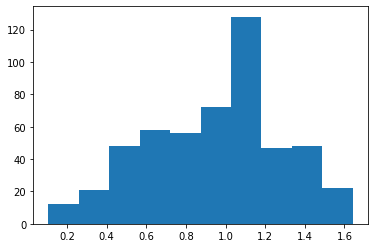

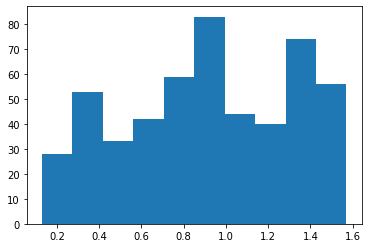

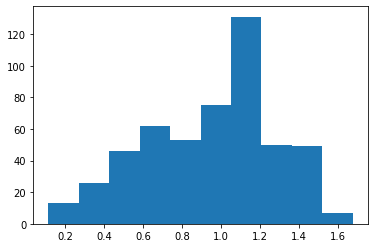

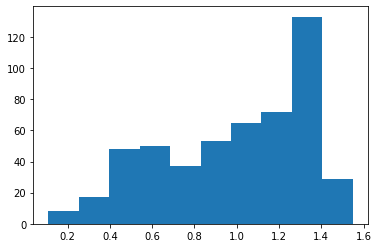

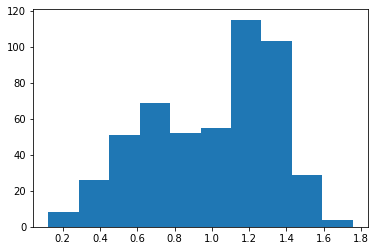

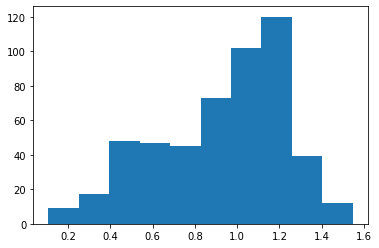

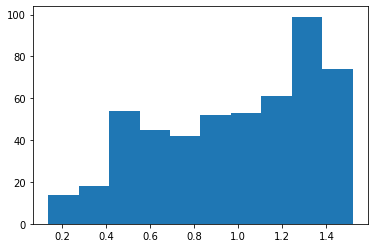

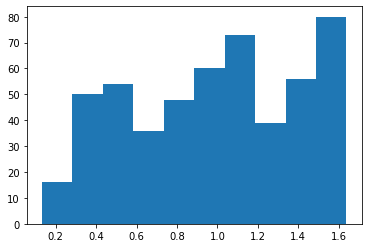

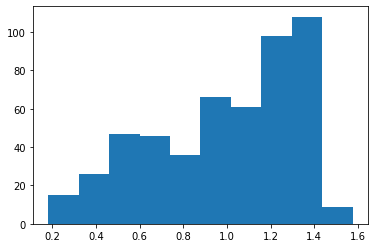

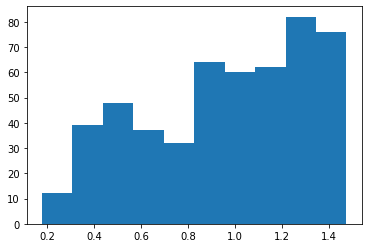

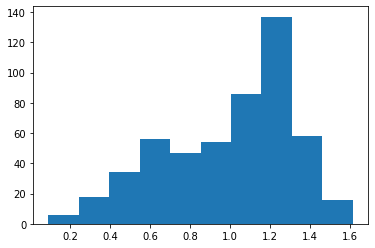

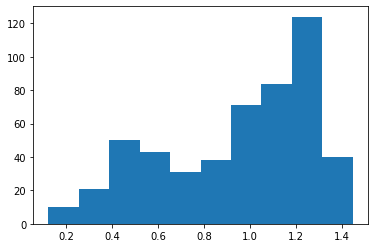

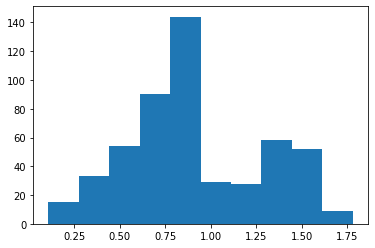

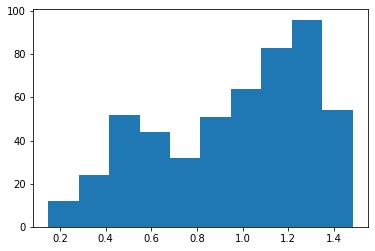

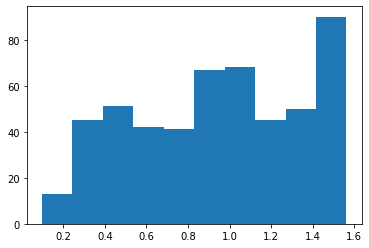

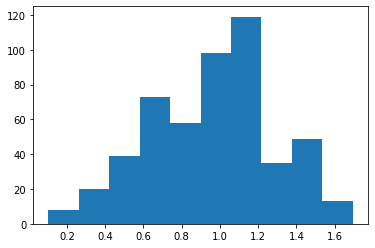

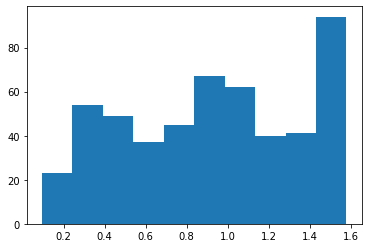

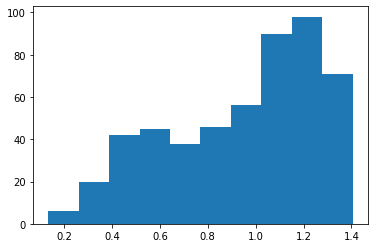

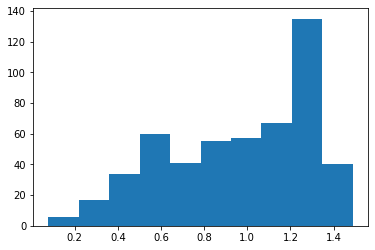

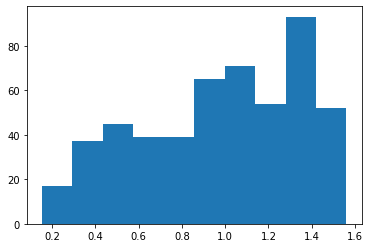

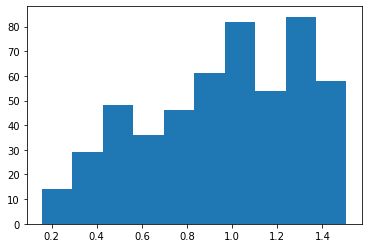

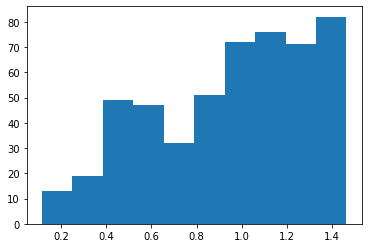

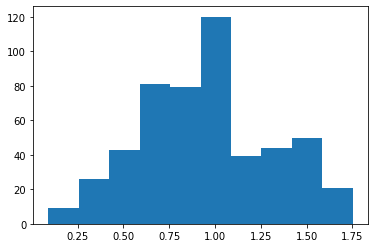

In [14]:
for i in range(60):
    plt.hist(bonafide_features[i])
    plt.show()

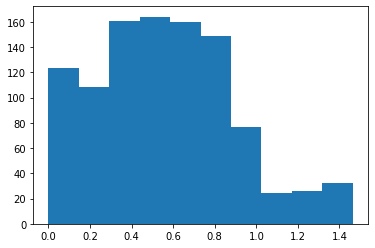

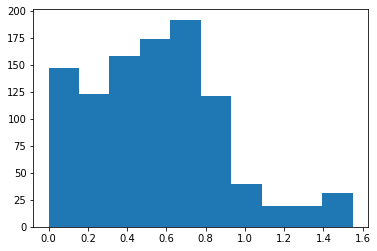

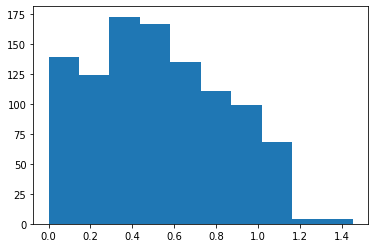

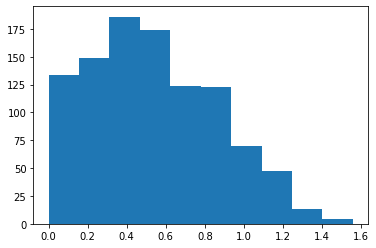

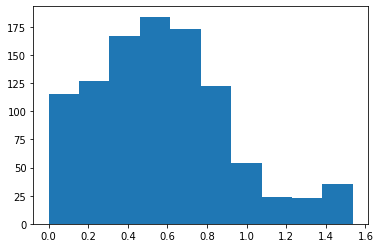

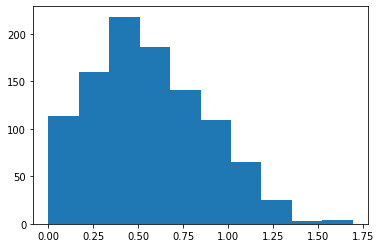

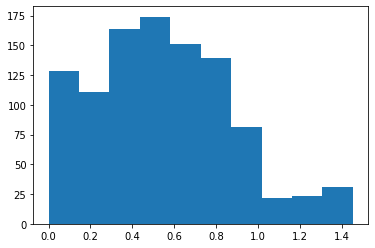

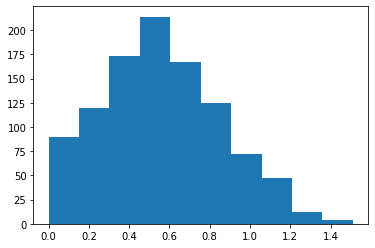

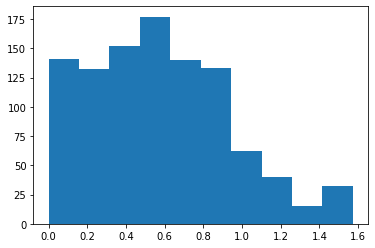

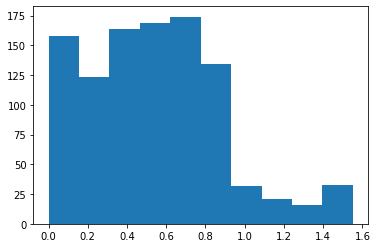

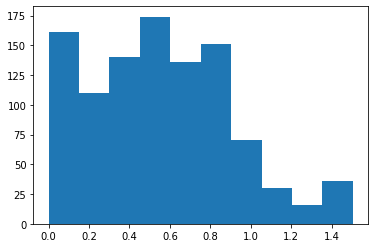

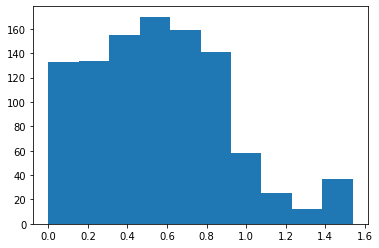

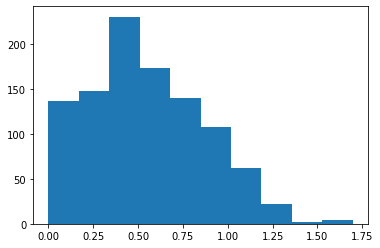

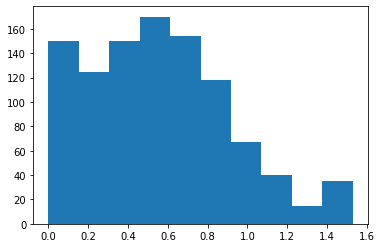

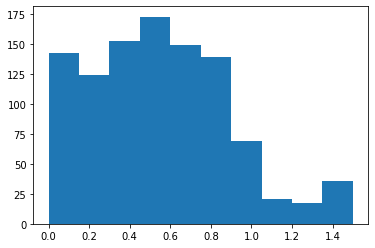

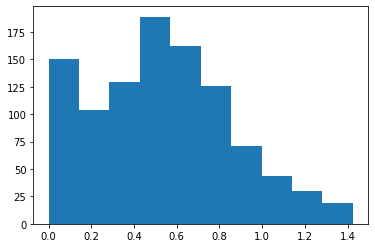

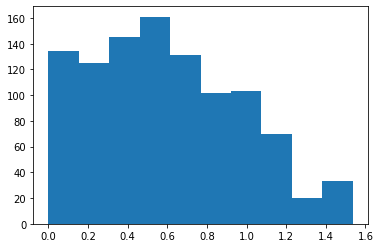

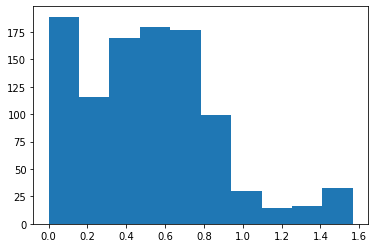

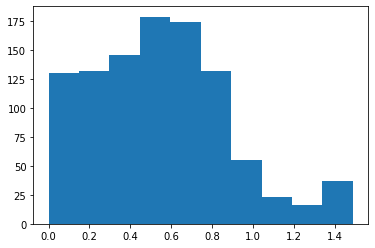

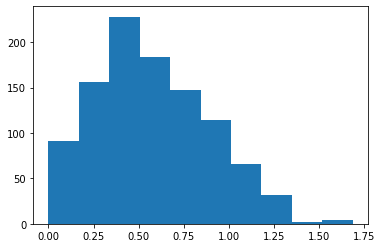

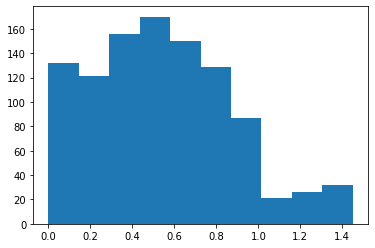

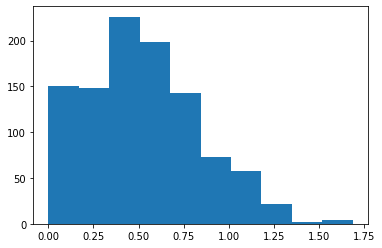

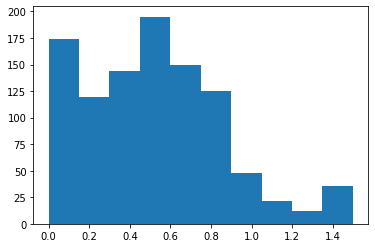

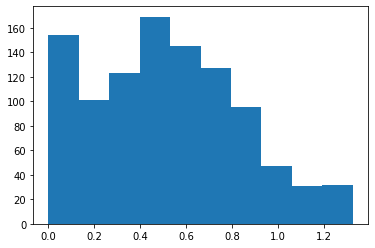

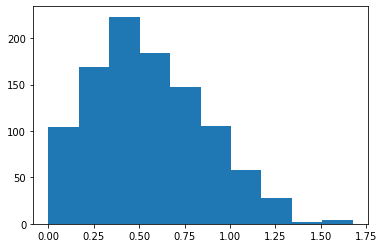

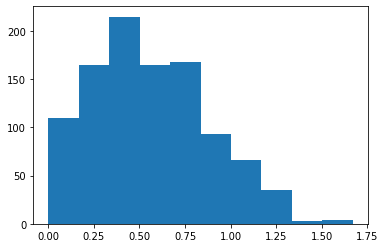

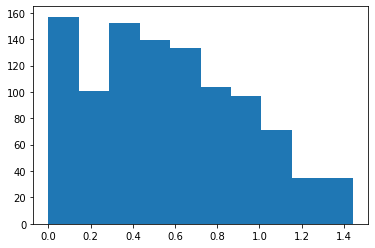

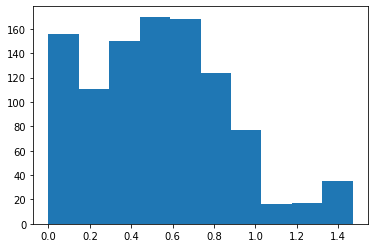

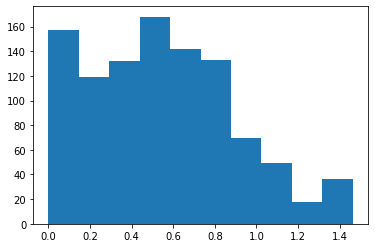

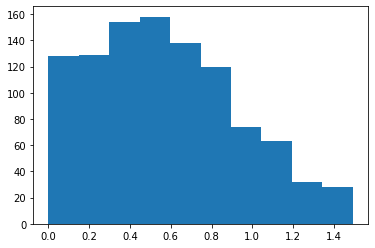

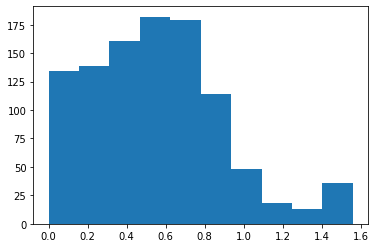

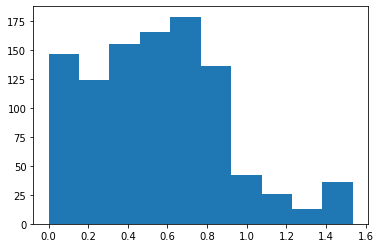

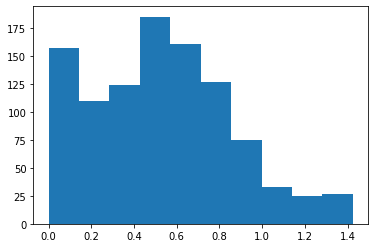

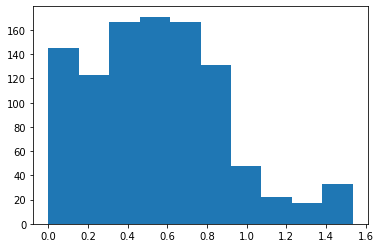

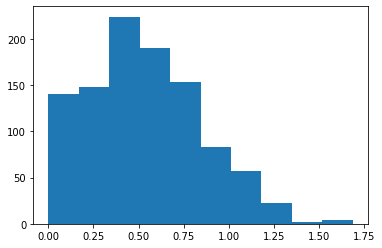

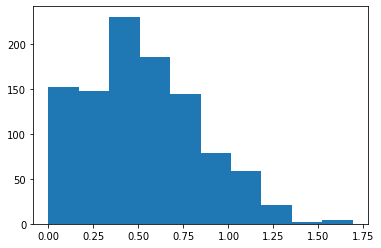

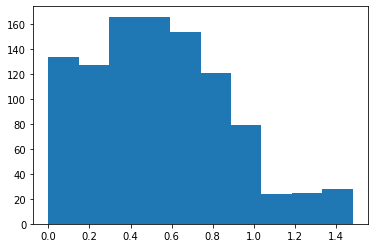

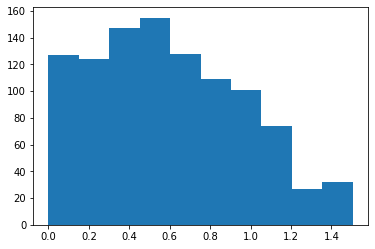

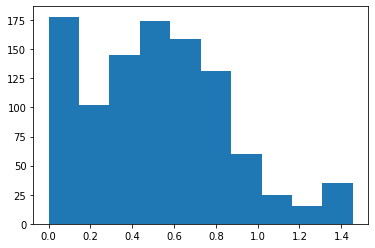

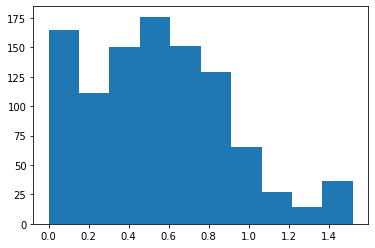

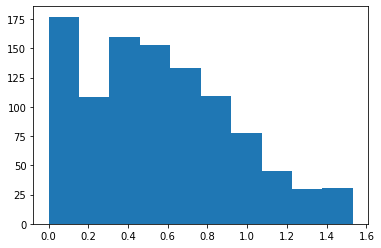

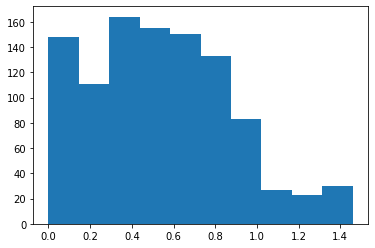

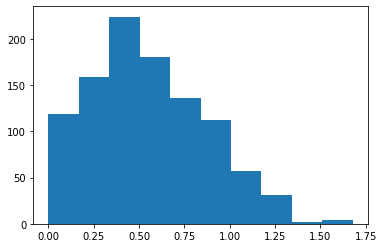

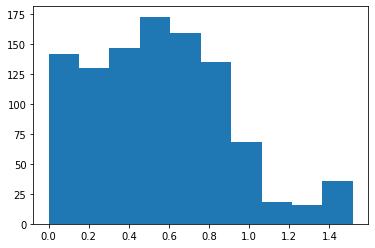

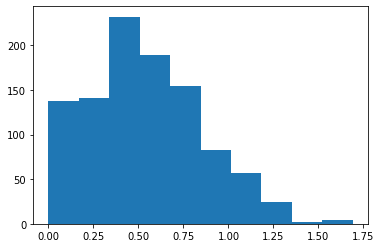

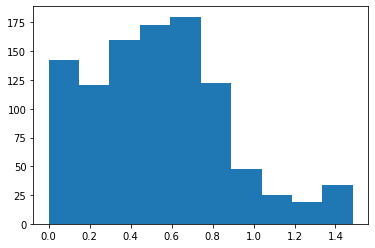

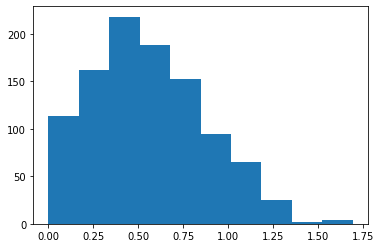

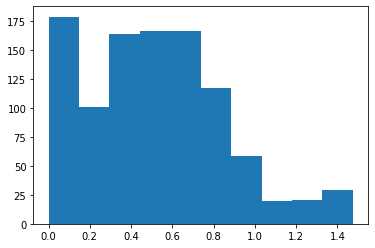

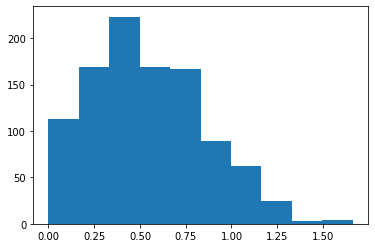

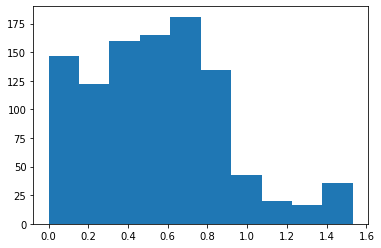

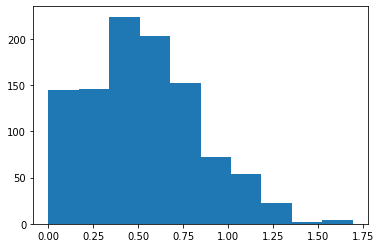

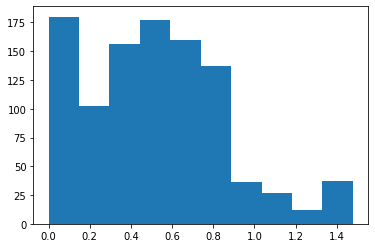

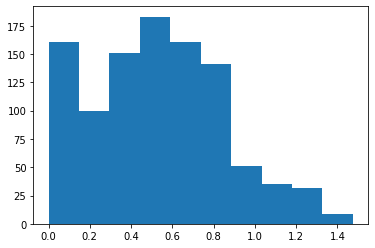

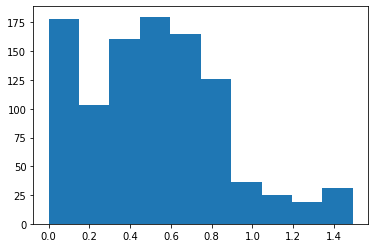

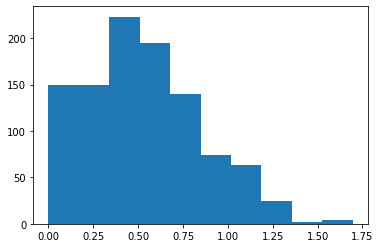

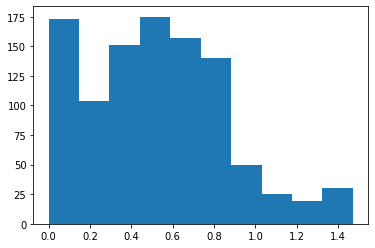

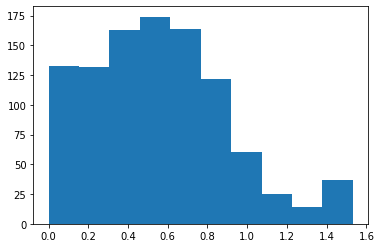

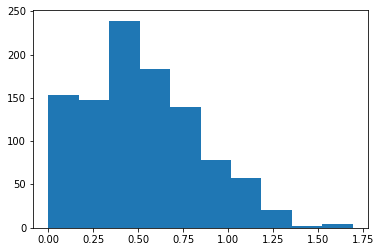

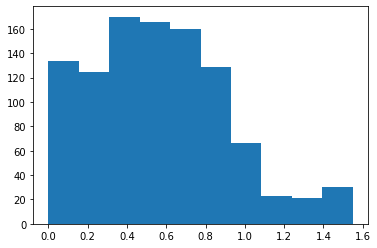

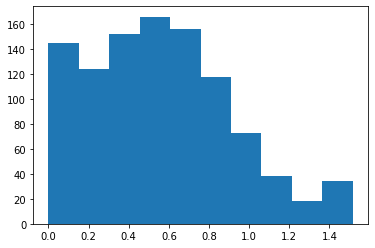

In [15]:
for i in range(60):
    plt.hist(v2_bonafide_features[i])
    plt.show()